# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Необходимо построить модель для задачи классификации, которая выберет подходящий тариф. 

Значение `accuracy` модели должно быть максимальным и больше, чем 0.75. Проверка `accuracy` должна производиться на тестовой выборке.

# Цель исследования

1. Выделить все компоненты, необходимые для обучения модели, которая будет предсказывать тарифный план пользователям
2. Рассмотреть разные модели с разными параметрами, выбрать среди них лучшие по значению `accuracy`
3. Проверить эти модели на тестовой выборке и выбрать лучшую среди лучших (необходимо также добиться того, чтобы `accuracy` был выше 0.73)
4. Проверить получившуюся модель на адекватность (цель со звездочкой)

# Ход работы

У нас есть датафрейм, содержащий данные о пользователях (их звонках, интернете, смсках) и тарифных планах, которые они используют. Необходимо прежде всего ознакомиться с ним, проверить типы данных, наличие пропусков и дубликатов. Затем необходимо разделить данные на три выборки: обучающую, валидационную и тестовую (в соотношении `3:1:1`). Затем необходимо будет обучить и проверить разные гиперпараметры на нескольких изученных нами моделях. Выбрать среди них лучшие по значению `accuracy`, а затем проверить их все на тестовой выборке (также получив для каждой значение `accuracy`). Выбрать модель с самым высоким `accuracy` на тестовой выборке (который также должен быть выше `0.73`) и проверить её на адекватность. После всего этого сделать соответствующие выводы. То есть у нас намечается 5 этапов:
- знакомство с данными, предобработка
- формовка выборок
- обучение моделей
- проверка лучших моделей на тестовой выборке
- проверка лучшей модели на адекватность

# Описание данных

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

Импортируем датасет в переменную `behavior` и выведем первые пять строк на экран, а также основную информацию о нём

In [9]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


behavior = pd.read_csv("/datasets/users_behavior.csv")
behavior.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [10]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Видим, что в нашем датафрейме 3214 строк, 5 столбцов, описание данных было представлено выше. Названия столбцов корректные, типы данных следует обновить, так как количество звонков и сообщений не может быть нецелочисленным.

Нет пропусков (ниже подсчетом показано)

In [11]:
behavior.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Приведем столбцы звонков и сообщений к целочисленному типу и выведем информацию об обновленном датафрейме на экран для проверки

In [12]:
behavior[['calls','messages']] = behavior[['calls','messages']].astype(int)
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


Привели требуемые столбцы к целочисленному виду

На всякий случай проверим, есть ли дубликаты

In [13]:
behavior.duplicated().sum()

0

Дубликатов нет, предобработка не требуется (за исключением аномальных данных, если есть), но, в принципе, в шапке проекта было написано, что предобработка не требуется, просто на всякий случай пощупал данные

Так какую задачу мы будем решать?

Перед нами стоит задача обучения модели, обучение с учителем (целевой признак полностью известен), а так как он (целевой признак) являет собой качественный признак, следовательно, это задача классификации. 

Проверим соотношение классов:

In [22]:
behavior.query('is_ultra == 0')['is_ultra'].count() # количество людей без тарифа ультра

2229

In [23]:
behavior.query('is_ultra == 1')['is_ultra'].count() # количество людей с тарифом ультра

985

In [24]:
behavior.query('is_ultra == 0')['is_ultra'].count()/behavior.query('is_ultra == 1')['is_ultra'].count() # соотношение

2.2629441624365483

Видим, что людей без тарифа у нас больше, чем людей с тарифом, примерно в 2.3 раза, что можно считать за дисбаланс классов, который решается, например, недосемплированием (недобор большего признака, чтобы был равен меньшему), пересемплированием (дублирование меньшего признака), взвешиванием (что проще всего).

Построим матрицу корреляции признаков:

In [25]:
behavior.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Визуаизируем корреляционную связь признаков:

In [33]:
import matplotlib.pyplot as plt
def show_corr_matrix(dataset, features, corr_method='pearson', figsize=(7, 7)):
    """Plots correlation matrix.

    Parameters
    ----------
    dataset: pd.DataFrame. Dataset with all data.
    features: array. Names of the features.
    corr_method: str. Method of correlation: 'pearson', 'kendall', 'spearman'. 
    figsize: tuple. Size of figure.

    Returns
    -------
    None.
    """
    # Get correlation matrix
    corr_matrix = dataset[features].corr(method=corr_method)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(
        corr_matrix,
        mask=mask,
        vmin=-1.,
        vmax=1.,
        annot=True,
        cmap='coolwarm'
    )
    plt.show()

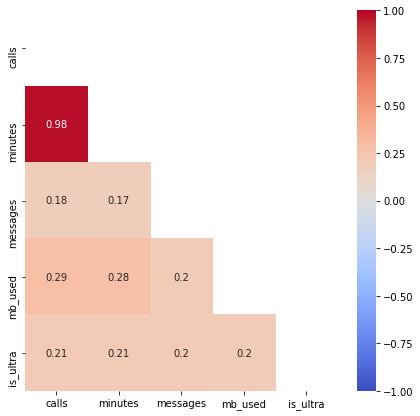

In [34]:
show_corr_matrix(behavior, behavior.columns)

Видим, что корреляция несвязанных признаков у нас низкая. Высокая она только для звонков и минут, но они явно связаны между собой.

Для оценки мультиколлинеарности рассчитаем определитель матрицы корреляции признаков:

In [35]:
np.linalg.det(behavior.corr())

0.02815406364542676

У нас наблюдается высокая мультиколлинеарность факторов, её можно решить с помощью отбора признаков методом графов (чтобы максимум признаков оставить, минимум исключить - минимум, который и даёт нам высокую мультиколлинеарность). На просторах интернета нашел алгоритм Брона-Кербоша, который ищет максимальные клики - подграфы, в которых все вершины соединены друг с другом. Таким образом можно добиться минимизации влияния мультиколлинеарности на прогноз модели.

### Промежуточный итог 1

Мы загрузили данные, рассмотрели их, выявили практически полное отсутствие необходимости в предобработке (нет пропусков, нет дубликатов). Только заменили типы звонков и сообщений на целочисленные.

Перед нами стоит задача обучения модели, обучение с учителем (целевой признак полностью известен), а так как он (целевой признак) являет собой качественный признак, следовательно, это задача классификации.

Проверили данные на дисбаланс, соотношение классов примерно 1:2.3, что может вызвать проблемы при дальнейшем решении.
Также выяснили, что у нас высокий уровень мультиколлинеарности данных, что также может влиять на итоговые параметры моделей.

## Разбейте данные на выборки

Необходимо сформировать выборки для дальнейшей работы с моделями.

Нам нужны обучающая, валидационная и тестовая выборки, но сначала нам надо понять, какой признак у нас целевой.

Обратимся к задаче нашего исследования - нам надо предложить клиентам новый тариф: `Смарт` или `Ультра`, следовательно, в целевой признак мы положим столбец `is_ultra` - его положим в переменную `target`, остальные признаки положим в переменную `features`. 

К остальным признакам у нас относятся количество звонков, суммарная длительность звонков в минутах, количество смс и израсходованный интернет-трафик в Мб - все эти признаки у нас точно подходят под то, что будет необходимо при планирвоании и учете, какой тариф предложить пользователю.

In [6]:
features = behavior.drop('is_ultra', axis = 1)
target = behavior['is_ultra']

Выведем первые пять строк новых переменных на экран, чтобы убедиться, что все правильно разделилось

In [7]:
features.head()

,calls,minutes,messages,mb_used
0,40,311.90,83,19915.42
1,85,516.75,56,22696.96
2,77,467.66,86,21060.45
3,106,745.53,81,8437.39
4,66,418.74,1,14502.75


In [8]:
target.head()

0    0
1    0
2    0
3    1
4    0
Name: is_ultra, dtype: int64

Теперь необходимо разделить данные на обучающую, валидационную и тестовую выборки. Делать это будем следующим образом: разделим на пять частей, три из которых пойдут на обучающую выборку, одна - на валидационную и оставшаяся - на тестовую выборку.

In [9]:
# сначала поделим выборку на две части: 0.8, которая будет содержать в себе обучающую 
# и тестовую выборки и 0.2 - валидационную
features_train_test, features_valid, \
target_train_test, target_valid =\
train_test_split(features, target, train_size = 0.8, test_size = 0.2, random_state = 12345)

# далее ту выборку, которая содержит в себе обучающую и тестовую, делим на 0.75 - обучающую
# и 0.25 - тестовую (0.75*0.8 = 0.6, 0.24*0.8 = 0.2), таким образом мы получили:
# 0.6 - обучающая выборка, 0.2 и 0.2 - валидационная и тестовая выборки соответственно.
features_train, features_test,\
target_train, target_test =\
train_test_split(features_train_test, target_train_test, train_size = 0.75, test_size = 0.25, random_state = 12345)

Убедимся, что размеры выборок соотносятся как 3:1:1:

In [10]:
features_train.shape[0]/features_test.shape[0]

2.998444790046656

In [11]:
features_train.shape[0]/features_valid.shape[0]

2.998444790046656

Видим, что обучающая выборка в три раза больше тестовой и валидационной, следователь, данные разбились правильно.

### Промежуточный итог 2

Мы выделили целевой признак (тариф), а также разделили выборки на обучающую, валидационную и тестовую в соотношении 3:1:1 и проверили размеры выборок.

## Исследуйте модели

На этом шаге мы обучим, валидируем и протестируем основные освоенные нами модели и в конце сделаем вывод, какая модель и с какими параметрами лучше всего предсказывает, какой тариф следует брать клиенту

### Решающее дерево

Первой нашей моделью будет дерево решений.
У него основным и самым важным гиперпараметром является `max_depth`, который мы будем оптимизировать до такого уровня, чтобы `accuracy` нашей модели был максимальный из возможных

In [12]:
depth_max = 0
accuracy_max = 0
best_model_decision_tree = None
for depth in range(1,16):  # перебираем максимальную глубину от 1 до 16 
                           # (захват с избытком, понятно, что уже после 5 должно быть что-то вроде переобучения)
    model = DecisionTreeClassifier(random_state= 12345, max_depth = depth)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    if accuracy >= accuracy_max:
        depth_max = depth
        accuracy_max = accuracy
        best_model_decision_tree = model

print('Max depth:', depth_max,'\nAccuracy max:', accuracy_max)

Max depth: 7 
Accuracy max: 0.7884914463452566


#### Вывод
Лучший `accuracy` модели решающего дерева `DecisionTreeClassifier` равен `0.7884914463452566` и достигается при значении гиперпараметра `max_depth`, равным `7`

### Случайный лес

Следующая модель, которую мы проверим, - это случайный лес. У него два основных гиперпараметра: `n_estimators` и `max_depth`, которые мы будем оптимизировать для получения максимальной `accuracy` модели:

In [13]:
depth_max = 0
est_max = 0
accuracy_max = 0
best_model_random_forest = None
for est in range(1,100, 5):
    for depth in range(1,16):
        model = RandomForestClassifier(random_state= 12345, n_estimators= est, max_depth = depth)
        model.fit(features_train, target_train)
        accuracy = model.score(features_valid, target_valid)
        if accuracy >= accuracy_max:
            depth_max = depth
            est_max = est
            accuracy_max = accuracy
            best_model_random_forest = model

print('Max depth:', depth_max,'\nN_estimators max:', est_max, '\nAccuracy max:', accuracy_max)

Max depth: 9 
N_estimators max: 96 
Accuracy max: 0.8040435458786936


#### Вывод
Лучший `accuracy` модели случайного леса `RandomForestClassifier` равен `0.8040435458786936` и достигается при значении гиперпараметров `n_estimators` и `max_depth`, равных `96` и `9` соответственно.

### Логистическая регрессия

Итоговая модель, которую необходимо проферить - логистическая регрессия

In [14]:
model = LogisticRegression(random_state=12345, solver='lbfgs') 
model.fit(features_train, target_train)
model_logistic_regression = model
print('Accuracy max:', model_logistic_regression.score(features_valid, target_valid))

Accuracy max: 0.7589424572317263


#### Вывод
Лучший `accuracy` модели логистической регрессии `LogisticRegression` равен `0.7589424572317263`.

### Промежуточный итог 3
Мы обучили три разные модели и перебрали гиперпараметры для них. Сохраняли те, которые показывали лучший `accuracy`:
- Лучший **`accuracy`** модели решающего дерева `DecisionTreeClassifier` равен **`0.7884914463452566`** и достигается при значении гиперпараметра `max_depth`, равным `7`

- Лучший **`accuracy`** модели случайного леса `RandomForestClassifier` равен **`0.8040435458786936`** и достигается при значении гиперпараметров `n_estimators` и `max_depth`, равных `96` и `9` соответственно.

- Лучший **`accuracy`** модели логистической регрессии `LogisticRegression` равен **`0.7589424572317263`**.

## Проверьте модель на тестовой выборке
Теперь проверим получившиеся модели на тестовой выборке

### Решающее дерево

Первой моделью на проверку будет решающее дерево. Её мы обучили и сохранили лучшую в переменной `best_model_decision_tree`. Её `accuracy` мы и проверим

In [15]:
best_model_decision_tree.score(features_test, target_test)

0.7744945567651633

#### Вывод
`accuracy` на тестовой выборке лучшей модели решающего дерева равен `0.7744945567651633`

### Случайный лес

Теперь проверим случайный лес. Эту модель мы сохранили в `best_model_random_forest`. Её `accuracy` мы и проверим

In [16]:
best_model_random_forest.score(features_test, target_test)

0.7884914463452566

#### Вывод
`accuracy` на тестовой выборке лучшей модели случайного леса равен `0.7884914463452566`

### Логистическая регрессия

Осталась модель логистической регрессии. Её мы сохраняли в `model_logistic_regression`

In [17]:
model_logistic_regression.score(features_test, target_test)

0.7262830482115086

#### Вывод
`accuracy` на тестовой выборке лучшей модели логистической регрессии равен `0.7262830482115086`

### Промежуточный итог 4

Получившиеся лучшие модели были проверены на тестовой выборке, в результате чего были получены следующие значения `accuracy`:
- `accuracy` на тестовой выборке лучшей модели решающего дерева равен `0.7744945567651633`
- `accuracy` на тестовой выборке лучшей модели случайного леса равен `0.7884914463452566`
- `accuracy` на тестовой выборке лучшей модели логистической регрессии равен `0.7262830482115086`

Видим, что:
- лучше всего предсказывает значения тестовой выборки модель случайного леса, 
- только для модели логистической регрессии не удалось достичь значения `accuracy` больше, чем `0.75`

## (бонус) Проверьте модели на адекватность

In [18]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy = 'most_frequent')
model.fit(features_train, target_train)

model.score(features_valid, target_valid)

0.6951788491446346

Видно, что `accuracy` модели `DummyClassifier` у нас `0.6951788491446346`, что ниже, чем у лучшей модели - случайного леса (`0.7884914463452566`), следовательно полученную нами модель можно считать адекватной

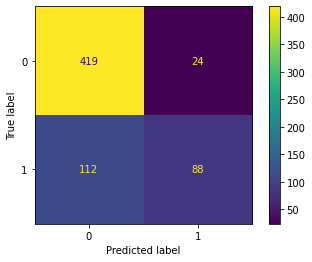

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

target_pred = best_model_random_forest.predict(features_test)
cm = confusion_matrix(target_test, target_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Для лучшей модели была построена `ConfusionMatrix`, которая показала следующие значения (см. выше). Рассмотрим же основные статистические маркеры качественных тестов (рассчитаны с помощью [калькулятора](https://statpages.info/ctab2x2.html), где была сформирована следующая таблица:

|                              | **Real positive value** | **Real negative value** |
|------------------------------|-------------------------|-------------------------|
| **Predicted positive value** |            88           |            24           |
| **Predicted negative value** |           112           |           419           |

В этом калькуляторе были получены следующие значения для прогностической ценности положительного и отрицательного результатов (positive predictive value и negative predictive value), а также чувствительности и специфичности (sensitivity и specificity):
- PPV = 0.786, 95% CI: (0.706; 0.851)
- NPV = 0.789, 95% CI: (0.772; 0.803)
- Sensitivity = 0.44, 95% CI: (0.395; 0.477)
- Specificity = 0.946, 95% CI: (0.926;0.962)

(CI - confidence interval)

Нижние границы доверительного интервала как для PPV, так и для NPV выше 0.7, а обычно принимают, что значения прогностической ценности выше, чем 0.7 (и ниже 0.8) уже говорят о хорошей прогностической ценности.

Нижняя граница для чувствительности (sensitivity) ниже 0.5, что говорит о плохой чувствительности.

Нижняя граница для специфичности (specificity) выше 0.9, что говорит о великолепной специфичности.

Также взглянем на преваленс нашей выборки, он равен 0.311, что является низким показателем.

Исходя из всего вышеперечисленного можно сказать, что на основании высоких значений specificity и npv, а также низких значений sensitivity и преваленса - данная модель хорошо работает как скрининговый тест и является вполне адекватной.

### Промежуточный итог 5

На основании модели `DummyClassifier`, а также статистического анализа, мы можем быть уверены в адекватности лучшей модели случайного леса.

# ИТОГ

Мы получили следующие выводы по шагам:

### Промежуточный итог 1

Мы загрузили данные, рассмотрели их, выявили практически полное отсутствие необходимости в предобработке (нет пропусков, нет дубликатов). Только заменили типы звонков и сообщений на целочисленные.

Перед нами стоит задача обучения модели, обучение с учителем (целевой признак полностью известен), а так как он (целевой признак) являет собой качественный признак, следовательно, это задача классификации.

Проверили данные на дисбаланс, соотношение классов примерно 1:2.3, что может вызвать проблемы при дальнейшем решении.
Также выяснили, что у нас высокий уровень мультиколлинеарности данных, что также может влиять на итоговые параметры моделей.

### Промежуточный итог 2

Мы выделили целевой признак (тариф), а также разделили выборки на обучающую, валидационную и тестовую в соотношении 3:1:1 и проверили размеры выборок.

### Промежуточный итог 3
Мы обучили три разные модели и перебрали гиперпараметры для них. Сохраняли те, которые показывали лучший `accuracy`:
- Лучший **`accuracy`** модели решающего дерева `DecisionTreeClassifier` равен **`0.7884914463452566`** и достигается при значении гиперпараметра `max_depth`, равным `7`

- Лучший **`accuracy`** модели случайного леса `RandomForestClassifier` равен **`0.8040435458786936`** и достигается при значении гиперпараметров `n_estimators` и `max_depth`, равных `96` и `9` соответственно.

- Лучший **`accuracy`** модели логистической регрессии `LogisticRegression` равен **`0.7589424572317263`**.

### Промежуточный итог 4

Получившиеся лучшие модели были проверены на тестовой выборке, в результате чего были получены следующие значения `accuracy`:
- `accuracy` на тестовой выборке лучшей модели решающего дерева равен `0.7744945567651633`
- `accuracy` на тестовой выборке лучшей модели случайного леса равен `0.7884914463452566`
- `accuracy` на тестовой выборке лучшей модели логистической регрессии равен `0.7262830482115086`

Видим, что:
- лучше всего предсказывает значения тестовой выборки модель случайного леса, 
- только для модели логистической регрессии не удалось достичь значения `accuracy` больше, чем `0.75`

### Промежуточный итог 5

На основании модели `DummyClassifier`, а также статистического анализа, мы можем быть уверены в адекватности лучшей модели случайного леса.

### Общий вывод исследования

На основании полученных нами данных и их разбивки на необходимые выборки мы обучили разные модели и выяснили, какая из них является лучшей по предсказанию тарифов пользователей (на основании данных о звонках, сообщениях, количестве Мб интернета).

Её `accuracy` нам удалось довести до значений, выше 0.75, а также проверили модель на адекватность путем сравнения со случайной и статистического анализа, убедившись в её правильности.

Итого, можем сказать, что у нас на руках есть модель, готовая по данным, которые я отметил раньше, с точностью 0.78-0.8 предсказать тариф для каждого конкретного пользователя.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
